# K-Nearest Neighbor Lab





In [131]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
import numpy as np
import matplotlib.pyplot as plt

from numpy import linalg as la
from scipy.io import arff
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from sklearn.model_selection import GridSearchCV

## 1. (40%) Correctly implement the k-nearest neighbor (KNN) algorithm and the KNN regression algorithm

### Code requirements
- Use Euclidean distance to decide closest neighbors. 
- Include optional distance weighting for both algorithms


In [120]:
class KNNClassifier(BaseEstimator,ClassifierMixin):
    def __init__(self, k=3, columntype=[], weight_type="inverse_distance", prob_type="cat"): ## add parameters here
        """
        Args:
            columntype for each column tells you if continues[real] or if nominal[categoritcal].
            weight_type: inverse_distance voting or if non distance weighting. Options = ["no_weight","inverse_distance"]
        """
        self.k = k
        self.columntype = columntype
        self.weight_type = weight_type
        self.prob_type = prob_type

    def fit(self, data, labels):
        """ Fit the data; run the algorithm (for this lab really just saves the data :D)
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
            y (array-like): A 2D numpy array with the training targets
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        self.data = data
        self.labels = labels
        
        return self
    
    def predict(self, data):
        """ Predict all classes for a dataset X
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        return np.array([self.single_predict(x) for x in data])

    def single_predict(self, x):
        dists = []
        if len(self.columntype) == 0:
            dists = np.array([la.norm(xi) for xi in (self.data - x)])
        else:
            dists = np.array([self.norm(x_val, x) for x_val in self.data])
        kn_dists = np.argsort(dists)[:self.k]

        if self.prob_type == "reg":
            labels = np.array([self.labels[i] for i in kn_dists])
            if self.weight_type == "no_weight":
                return np.sum(labels) / self.k
            elif self.weight_type == "inverse_distance":
                weights = np.array([self.weight(dists[j]) for j in kn_dists])
                return np.dot(labels, weights) / np.sum(weights)

        elif self.prob_type == "cat":
            total = lambda label: sum([self.weight(dists[i]) for i in kn_dists 
                                    if self.labels[i] == label])
            label_sums = {label: total(label) for label in np.unique(self.labels[kn_dists])}
            best = max(label_sums, key=label_sums.get)
            return best

        raise ValueError(f"Error: prob_type: {self.prob_type}, weight_type: {self.weight_type}")
    

    def weight(self, x):
        if self.prob_type == "reg":
            return x
        elif self.prob_type == "cat":
            if self.weight_type == "no_weight":
                return 1
            elif self.weight_type == "inverse_distance":
                if x == 0:
                    return np.inf
                return 1 / (x ** 2)
        raise ValueError("Error: Invalid weight type:", self.weight_type)
    
    def norm(self, x_val , x):
        total = 0
        for i, feat_type in enumerate(self.columntype):
            if feat_type == "real":
                total += np.abs(x_val[i] - x[i])
            elif x_val[i] != x[i]
                total += 0.5
        return total

    #Returns the Mean score given input data and labels
    def score(self, X, y):
        """ Return accuracy of model on a given dataset. Must implement own score function.
        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 2D numpy array with targets
        Returns:
            score : float
                Mean accuracy of self.predict(X) wrt. y.
        """
        predictions = self.predict(X)
        if self.prob_type == "cat":
            correct = sum([1 for i, z in enumerate(predictions) if z == y[i]])
            return correct / len(y)
        err = sum([((y[i] - z)**2) for i, z in enumerate(predictions)])
        return err / len(y)

## 1.1 Debug and Evaluation

Debug and Evaluate your model using the parameters below:

- Use distance weighting
- KNN = 3 (three nearest neighbors)
- Don’t normalize the data
- Use Euclidean Distance

---

### 1.1.1 Debug

- Use this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/glass_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/glass_test.arff)
- Use distance weighting
- KNN = 3 (three nearest neighbors)
- Don’t normalize the data
- Use Euclidean Distance

Expected Results:
- Not using inverse weighted distancing = roughly [66.28%]
- Link to [debug solution](https://github.com/cs472ta/CS472/blob/master/debug_solutions/glass_no_inv_prediction.csv)

- Using inverse weighted distancing = roughly [73.26%]
- Link to [debug solution](https://github.com/cs472ta/CS472/blob/master/debug_solutions/glass_inv_prediction.csv)


In [102]:
# Load glass train data
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/glass_train.arff --output glass_train.arff &> /dev/null
glass_train = arff.loadarff("glass_train.arff")

# Encode categorical to numeric
glass_train_df = pd.DataFrame(glass_train[0])
glass_train_df["Type"] = LabelEncoder().fit_transform(glass_train_df["Type"])
glass_train_np = np.array(glass_train_df)

# Split off labels
glass_train_x, glass_train_y = glass_train_np[:,:-1], glass_train_np[:,-1]

# No weighting =================================================================
# Train on training set
glass_knn = KNNClassifier(weight_type="no_weight")
glass_knn.fit(glass_train_x, glass_train_y)

# Load glass test data
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/glass_test.arff --output glass_test.arff &> /dev/null
glass_test_data = arff.loadarff("glass_test.arff")

# # Encode categorical to numeric
glass_test_df = pd.DataFrame(glass_test_data[0])
glass_test_df["Type"] = LabelEncoder().fit_transform(glass_test_df["Type"])
glass_test_np = np.array(glass_test_df)
# Split off labels
glass_test_x, glass_test_y = glass_test_np[:,:-1], glass_test_np[:,-1]

# Predict and compute model accuracy
accuracy = glass_knn.score(glass_test_x, glass_test_y)
print("No weighting accuracy:", round(accuracy, 4))


# Inverse distance =============================================================
# Train on training set
glass_knn = KNNClassifier()
glass_knn.fit(glass_train_x, glass_train_y)

# Predict and compute model accuracy
accuracy = glass_knn.score(glass_test_x, glass_test_y)
print("Inverse distance accuracy:", round(accuracy, 4))


No weighting accuracy: 0.6829
Inverse distance accuracy: 0.7439


### 1.1.2 Evaluate

We will evaluate your model based on its performance on the [diabetes](https://archive.ics.uci.edu/ml/datasets/Diabetes) problem.
- Use this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/diabetes_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/diabetes_test.arff)

In [103]:
# Load diabetes train data
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/diabetes_train.arff --output diabetes_train.arff &> /dev/null
diabetes_train = arff.loadarff("diabetes_train.arff")

# Encode categorical to numeric
diabetes_train_df = pd.DataFrame(diabetes_train[0])

diabetes_train_df["class"] = LabelEncoder().fit_transform(diabetes_train_df["class"])
diabetes_train_np = np.array(diabetes_train_df)

# Split off labels
diabetes_train_x, diabetes_train_y = diabetes_train_np[:,:-1], diabetes_train_np[:,-1]

# No weighting =========================================================================
# Train on training set
diabetes_knn = KNNClassifier()
diabetes_knn.fit(diabetes_train_x, diabetes_train_y)

# Load diabetes test data
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/diabetes_test.arff --output diabetes_test.arff &> /dev/null
diabetes_test_data = arff.loadarff("diabetes_test.arff")

# Encode categorical to numeric
diabetes_test_df = pd.DataFrame(diabetes_test_data[0])
diabetes_test_df["class"] = LabelEncoder().fit_transform(diabetes_test_df["class"])
diabetes_test_np = np.array(diabetes_test_df)
# Split off labels
diabetes_test_x, diabetes_test_y = diabetes_test_np[:,:-1], diabetes_test_np[:,-1]

# Predict and compute model accuracy
accuracy = diabetes_knn.score(diabetes_test_x, diabetes_test_y)
print("Accuracy:", round(accuracy, 4))

Accuracy: 0.8906


## 2. (10%) Use the k-nearest neighbor algorithm (without distance weighting) for the [magic telescope](http://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope) problem

- Use this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_test.arff) 

### 2.1
- Try it with k=3 and without normalization


In [105]:
# Load magic telescope train data
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_train.arff --output magic_telescope_train.arff &> /dev/null
mt_train = arff.loadarff("magic_telescope_train.arff")

# Encode all categorical to numeric
mt_train_df = pd.DataFrame(mt_train[0])
mt_train_df["class"] = LabelEncoder().fit_transform(mt_train_df["class"])
mt_train_np = np.array(mt_train_df)
# Split off labels
mt_train_x, mt_train_y = mt_train_np[:,:-1], mt_train_np[:,-1]

# Load magic telescope test data
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_test.arff --output magic_telescope_test.arff &> /dev/null
mt_test = arff.loadarff("magic_telescope_test.arff")

# Encode all categorical to numeric
mt_test_df = pd.DataFrame(mt_test[0])
mt_test_df["class"] = LabelEncoder().fit_transform(mt_test_df["class"])
mt_test_np = np.array(mt_test_df)
# Split off labels
mt_test_x, mt_test_y = mt_test_np[:,:-1], mt_test_np[:,-1]

# Train/Predict without normalization
mt_knn = KNNClassifier(weight_type="no_weight")
mt_knn.fit(mt_train_x, mt_train_y)
acc = mt_knn.score(mt_test_x, mt_test_y)
print("Accuracy:", round(acc, 4))

Accuracy: 0.8083


### 2.2
- Try it with k=3 and with normalization (input features normalized between 0 and 1). Use the normalization formula (x-xmin)/(xmax-xmin)

In [22]:
def norm(x):
    xmin = x.min(axis=0) 
    xmax = x.max(axis=0)
    return (x - xmin) / (xmax - xmin)

In [124]:
# Train/Predict with normalization
mt_norm_knn = KNNClassifier(weight_type="no_weight")
mt_norm_knn.fit(norm(mt_train_x), mt_train_y)
acc = mt_norm_knn.score(norm(mt_test_x), mt_test_y)
print("Accuracy:", round(acc, 4))

Accuracy: 0.8158


Normalized data did ~1% better.

### 2.3

- Using your normalized data, create one graph with classification accuracy on the test set over k values. 
    - Use odd values of k from 1 to 15.
- As a rough sanity check, typical knn accuracies for the magic telescope data set are 75-85%

Accuracy for k=1: 0.7883
Accuracy for k=3: 0.81
Accuracy for k=5: 0.8233
Accuracy for k=7: 0.8417
Accuracy for k=9: 0.8433
Accuracy for k=11: 0.8433
Accuracy for k=13: 0.8483
Accuracy for k=15: 0.8467


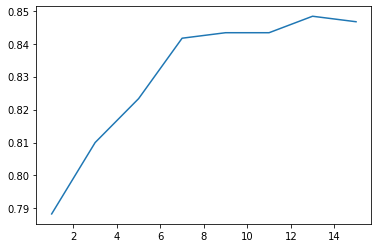

In [12]:
# Train/Predict with normalization using k=1,3,...,15
accs = []
domain = np.arange(1, 16, 2)
for k_val in domain:
    mt_norm_knn = KNNClassifier(k=k_val, weight_type="no_weight")
    mt_norm_knn.fit(norm(mt_train_x), mt_train_y)
    selection = np.random.randint(1, len(mt_test_x), 400)
    acc = mt_norm_knn.score(norm(mt_test_x[selection]), mt_test_y[selection])
    print("Accuracy for k=" + str(k_val) + ":", round(acc, 4))
    accs.append(acc)

# Graph classification accuracy over k
plt.plot(domain, accs)
plt.show()

# For the rest of the experiments use only normalized data

## 3. (10%) Use the regression variation of your algorithm (without distance weighting) for the [housing price prediction](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) problem.

- Use this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_test.arff).
- Use Mean Square Error (MSE) on the test set as your accuracy metric for this case.
    - Do not normalize regression output values
- Graph MSE on the test set with odd values of k from 1 to 15


SME for k=1: 23.581
SME for k=3: 14.2154
SME for k=5: 16.3183
SME for k=7: 20.0287
SME for k=9: 20.1412
SME for k=11: 21.2745
SME for k=13: 22.4082
SME for k=15: 22.585


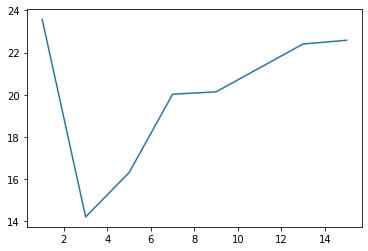

In [123]:
# Load housing price prediction data
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_train.arff --output housing_train.arff &> /dev/null
housing_train = arff.loadarff("housing_train.arff")

# Encode all categorical to numeric
housing_train_df = pd.DataFrame(housing_train[0])
housing_train_df["CHAS"] = LabelEncoder().fit_transform(housing_train_df["CHAS"])
housing_train_np = np.array(housing_train_df)
# Split off labels
housing_train_x, housing_train_y = housing_train_np[:,:-1], housing_train_np[:,-1]

# Load magic telescope test data
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_test.arff --output housing_test.arff &> /dev/null
housing_test = arff.loadarff("housing_test.arff")

# Encode all categorical to numeric
housing_test_df = pd.DataFrame(housing_test[0])
housing_test_df["CHAS"] = LabelEncoder().fit_transform(housing_test_df["CHAS"])
housing_test_np = np.array(housing_test_df)
# Split off labels
housing_test_x, housing_test_y = housing_test_np[:,:-1], housing_test_np[:,-1]

# Train/Predict using k=1,3,...,15
accs = []
domain = np.arange(1, 16, 2)
for k_val in domain:
    housing_knn = KNNClassifier(k=k_val, weight_type="no_weight", prob_type="reg")
    housing_knn.fit(norm(housing_train_x), housing_train_y)
    acc = housing_knn.score(norm(housing_test_x), housing_test_y)
    print("SME for k=" + str(k_val) + ":", round(acc, 4))
    accs.append(acc)

# Graph MSE over k
plt.plot(domain, accs)
plt.show()

## 4. (15%) Repeat your experiments for magic telescope and housing using distance-weighted (inverse of distance squared) voting and discuss your results.


## 4.1 Magic Telescope Dataset

Accuracy for k=1: 0.805
Accuracy for k=3: 0.775
Accuracy for k=5: 0.81
Accuracy for k=7: 0.825
Accuracy for k=9: 0.82
Accuracy for k=11: 0.785
Accuracy for k=13: 0.71
Accuracy for k=15: 0.75


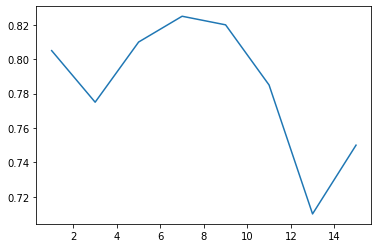

In [126]:
# Train/Predict using k=1,3,...,15
accs = []
domain = np.arange(1, 16, 2)
for k_val in domain:
    mt_knn = KNNClassifier(weight_type="inverse_distance")
    mt_knn.fit(norm(mt_train_x), mt_train_y)
    selection = np.random.randint(1, len(mt_test_x), 200)
    acc = mt_knn.score(norm(mt_test_x[selection]), mt_test_y[selection])
    print("Accuracy for k=" + str(k_val) + ":", round(acc, 4))
    accs.append(acc)

# Graph MSE over k
plt.plot(domain, accs)
plt.show()

## 4.2 Housing Dataset

SME for k=1: 23.581
SME for k=3: 15.8101
SME for k=5: 19.3005
SME for k=7: 24.443
SME for k=9: 22.2645
SME for k=11: 23.5429
SME for k=13: 24.8507
SME for k=15: 25.262


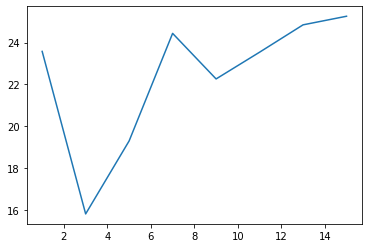

In [127]:
# Train/Predict housing using distance-weighted voting
housing_knn = KNNClassifier(k=k_val, weight_type="inverse_distance", prob_type="reg")
housing_knn.fit(norm(housing_train_x), housing_train_y)
acc = housing_knn.score(norm(housing_test_x), housing_test_y)


# Train/Predict using k=1,3,...,15
accs = []
domain = np.arange(1, 16, 2)
for k_val in domain:
    housing_knn = KNNClassifier(k=k_val, weight_type="inverse_distance", prob_type="reg")
    housing_knn.fit(norm(housing_train_x), housing_train_y)
    acc = housing_knn.score(norm(housing_test_x), housing_test_y)
    print("SME for k=" + str(k_val) + ":", round(acc, 4))
    accs.append(acc)

# Graph MSE over k
plt.plot(domain, accs)
plt.show()

Weighting really didn't make much of a difference. It actually looks like it made the accuracy worse. However, it looks like for the magic telescope problem, it peaked at 9 neighbors rather than 3 when there was no distance weighting.

## 5. (10%) Use the k-nearest neighbor algorithm to solve the [credit-approval](https://archive.ics.uci.edu/ml/datasets/Credit+Approval) (credit-a) problem.

- Use this [dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/credit_approval.arff)
    - Use a 70/30 split of the data for the training/test set
- Note that this set has both continuous and nominal attributes, together with don’t know values. 
- Implement and justify a distance metric which supports continuous, nominal, and don’t know attribute values
    - You need to handle don't knows with the distance metric, not by imputing a value.
    - More information on distance metrics can be found [here](https://www.jair.org/index.php/jair/article/view/10182/24168).
- Use your own choice for k.
- As a rough sanity check, typical knn accuracies for the credit data set are 70-80%.


Round 0 accuracy: 0.714975845410628
Round 1 accuracy: 0.7439613526570048
Round 2 accuracy: 0.7198067632850241
Round 3 accuracy: 0.6859903381642513
Round 4 accuracy: 0.7246376811594203
Round 5 accuracy: 0.6956521739130435
Round 6 accuracy: 0.7729468599033816
Round 7 accuracy: 0.6956521739130435
Round 8 accuracy: 0.7246376811594203
Round 9 accuracy: 0.714975845410628
Low accuracy: 0.6859903381642513
High accuracy: 0.7729468599033816
Average accuracy: 0.7193236714975845


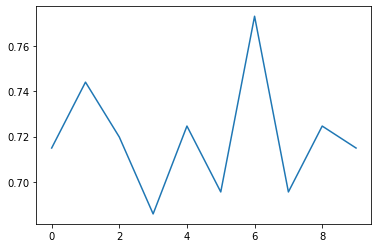

In [130]:
# Load dataset and split into train/test sets
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/credit_approval.arff --output credit_approval.arff &> /dev/null
ca_data = arff.loadarff("credit_approval.arff")

# Encode all categorical to numeric
ca_df = pd.DataFrame(ca_data[0])
ca_catagorical_ats = ["A1", "A4", "A5", "A6", "A7", 
                      "A9", "A10", "A12", "A13", "class"]
for at in ca_catagorical_ats:
    ca_df[at] = LabelEncoder().fit_transform(ca_df[at])

# Replace missing values
replace_dict = {"A1": {np.nan: int(ca_df.A1.mode())}, 
                "A2": {np.nan: ca_df.A2.mean()}, 
                "A4": {np.nan: int(ca_df.A4.mode())},
                "A5": {np.nan: int(ca_df.A5.mode())},
                "A6": {np.nan: int(ca_df.A6.mode())},
                "A7": {np.nan: int(ca_df.A7.mode())},
                "A14": {np.nan: ca_df.A14.mean()}}
ca_df.replace(replace_dict, inplace=True)
ca_np = np.array(ca_df)

accs = []
for i in range(10):
    # Split into training and testing data
    np.random.shuffle(ca_np)
    part = round(.7 * len(ca_np))
    ca_train, ca_test = ca_np[:part], ca_np[part:]

    # Split off labels
    ca_train_x, ca_train_y = ca_train[:,:-1], ca_train[:,-1]
    ca_test_x, ca_test_y = ca_test[:,:-1], ca_test[:,-1]
    # Train/Predict credit-approval
    feat_types = ["cat", "real", "real", "cat", "cat", "cat", "cat", "real",
                  "cat", "cat", "real", "cat", "cat", "real", "real"]
    ca_knn = KNNClassifier(k=5, columntype=feat_types, weight_type="inverse_distance")
    ca_knn.fit(norm(ca_train_x), ca_train_y)
    acc = ca_knn.score(norm(ca_test_x), ca_test_y)
    print(f"Round {i} accuracy: {acc}")
    accs.append(acc)
print(f"Low accuracy: {min(accs)}")
print(f"High accuracy: {max(accs)}")
print(f"Average accuracy: {sum(accs)/len(accs)}")
plt.plot(accs)
plt.show()

The distance metric is as follows: compare feature by feature and if the feature is real valued, take the absolute value of their difference, if the feature is categorical and they differ, add 0.5 to the distance. I replaced the missing data with means and modes so I didn't check for them in the distance metric.

## 6. (15%) Use the scikit's KNN Classifier on magic telescope and KNN Regressor on housing and compare your results.

- Try out different hyperparameters to see how well you can do. 


In [133]:
# Train/Predict magic telescope using scikit's KNN
parameters = {'n_neighbors': [1, 3, 5, 9, 17], "weights": ("uniform", "distance")}
mt_knn = KNeighborsClassifier()
clf = GridSearchCV(mt_knn, parameters)
clf.fit(norm(mt_train_x), mt_train_y)
acc = clf.score(norm(mt_test_x), mt_test_y)
print(f"Magic telescope accuracy: {acc}")

# Train/Predict housing using scikit's KNN
housing_knn = KNeighborsRegressor()
clf = GridSearchCV(housing_knn, parameters)
clf.fit(norm(housing_train_x), housing_train_y)
acc = clf.score(norm(housing_test_x), housing_test_y)
print(f"Housing R^2 error: {acc}")

Magic telescope accuracy: 0.8288328832883288
Housing R^2 error: 0.7870791076943359


For the magic telescope probelem, it's ~1% better. That said, my algorithm took ~8 minutes while scikits look less than a second. For the housing problem, i'm not sure how to compare because we use difference error metrics.

## 7. (optional 5% extra credit): For the best value of k for any one of the datasets, implement a reduction algorithm that removes data points in some rational way such that performance does not drop too drastically on the test set given the reduced training set.

- Compare your performance on the test set for the reduced and non-reduced versions and give the number (and percentage) of training examples removed from the original training set. How well does your reduction algorithm work?
    - Note that performance for magic telescope is classification accuracy and for housing it is mean squared error.
    - Magic Telescope has about 12,000 instances and if you use a leave one out style of testing for your data set reduction, then your algorithm will run slow since that is n2 at each step.
    - If you wish, you may use a random subset of 2,000 of the magic telescope instances.
    - More information on reduction techniques can be found [here](http://axon.cs.byu.edu/~martinez/classes/478/slides/IBL.pdf).
